In [1]:
import pandas as pd
from google.colab import files
import io
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving CRWV_2025-04-03 00_00_00+00_00.csv to CRWV_2025-04-03 00_00_00+00_00.csv


In [3]:
df['ts_event'] = pd.to_datetime(df['ts_event'])
df['minute'] = df['ts_event'].dt.floor('T')

/tmp/ipython-input-3376387431.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['ts_event'].dt.floor('T')


In [4]:
# Pick the midpoint record for each minute
snapshots = []
for minute in df['minute'].unique():
    minute_df = df[df['minute'] == minute].sort_values('ts_event')
    if len(minute_df) > 0:
        mid_index = len(minute_df) // 2
        snapshots.append(minute_df.iloc[mid_index])

snapshot_df = pd.DataFrame(snapshots)

# Normalize price columns (stored as integers, need to divide by 1e9)
for i in range(1, 11):
    suffix = f'0{i}' if i < 10 else f'{i}'
    px_col = f'ask_px_{suffix}'
    px_col = f'bid_px_{suffix}'

# Compute midpoint price
snapshot_df['midpoint'] = (snapshot_df['ask_px_01'] + snapshot_df['bid_px_01']) / 2

In [5]:
# Simulate VWAP function using top 10 levels
def simulate_vwap(row, shares_to_buy):
    ask_levels = []
    for i in range(1, 11):
        suffix = f'0{i}' if i < 10 else f'{i}'
        px_col = f'ask_px_{suffix}'
        sz_col = f'ask_sz_{suffix}'
        if px_col in row and sz_col in row:
            price = row[px_col]
            size = row[sz_col]
            if pd.isna(price) or pd.isna(size):
                continue
            ask_levels.append((price, int(size)))

    ask_levels.sort(key=lambda x: x[0])
    shares_bought = 0
    total_cost = 0.0
    for price, size in ask_levels:
        if shares_bought + size <= shares_to_buy:
            total_cost += price * size
            shares_bought += size
        else:
            fill = shares_to_buy - shares_bought
            total_cost += price * fill
            shares_bought += fill
            break

    if shares_bought == 0:
        return np.nan, 0
    return total_cost / shares_bought, shares_bought

In [6]:
# Step 1: Calculate slippage per share using a small test order (ie, 5 shares)
sample_shares = 5
slippage_per_share = []
for idx, row in snapshot_df.iterrows():
    vwap, _ = simulate_vwap(row, sample_shares)
    if np.isnan(vwap):
        slippage_per_share.append(np.inf)
    else:
        slippage = vwap - row['midpoint']
        slippage_per_share.append(slippage)

snapshot_df['slippage_per_share'] = slippage_per_share

print (snapshot_df['slippage_per_share'])

662       0.270
2787      0.310
4783      0.085
5966      0.110
7001      0.235
          ...  
183680    0.025
184616    0.020
185764    0.030
187039    0.080
188778    0.065
Name: slippage_per_share, Length: 390, dtype: float64


In [7]:
# Step 2: Allocate S (500) shares to minimize slippage
S = 500
valid_slippage = snapshot_df['slippage_per_share'].replace([np.inf, -np.inf], np.nan).dropna()
weights = 1 / valid_slippage
weights = weights / weights.sum()
allocation = (weights * S).round().astype(int)

# Step 3: Store allocation
snapshot_df = snapshot_df.loc[valid_slippage.index].copy()
snapshot_df['x_t_allocated'] = allocation

# Preview results
print(snapshot_df[['minute', 'slippage_per_share', 'x_t_allocated']])

                          minute  slippage_per_share  x_t_allocated
662    2025-04-03 13:30:00+00:00               0.270              0
2787   2025-04-03 13:31:00+00:00               0.310              0
4783   2025-04-03 13:32:00+00:00               0.085              1
5966   2025-04-03 13:33:00+00:00               0.110              1
7001   2025-04-03 13:34:00+00:00               0.235              0
...                          ...                 ...            ...
183680 2025-04-03 19:55:00+00:00               0.025              4
184616 2025-04-03 19:56:00+00:00               0.020              5
185764 2025-04-03 19:57:00+00:00               0.030              3
187039 2025-04-03 19:58:00+00:00               0.080              1
188778 2025-04-03 19:59:00+00:00               0.065              1

[390 rows x 3 columns]


In [8]:
# Temporary Impact function
def plot_temporary_impact(row, max_shares=S):
    midpoint = row['midpoint']

    slippage = []
    order_sizes = list(range(1, max_shares + 1))

    for x in order_sizes:
        vwap, shares_bought = simulate_vwap(row, x)
        if vwap is not None and not np.isnan(vwap):
            slippage.append(vwap - midpoint)
        else:
            break

    plt.figure(figsize=(10, 6))
    plt.plot(order_sizes[:len(slippage)], slippage, label='gₜ(x) = VWAP(x) - Midpoint')
    plt.xlabel('Order Size (x)')
    plt.ylabel('Slippage ($)')
    plt.title('Temporary Market Impact Function CRWV - Midpoint record first minute of trading')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


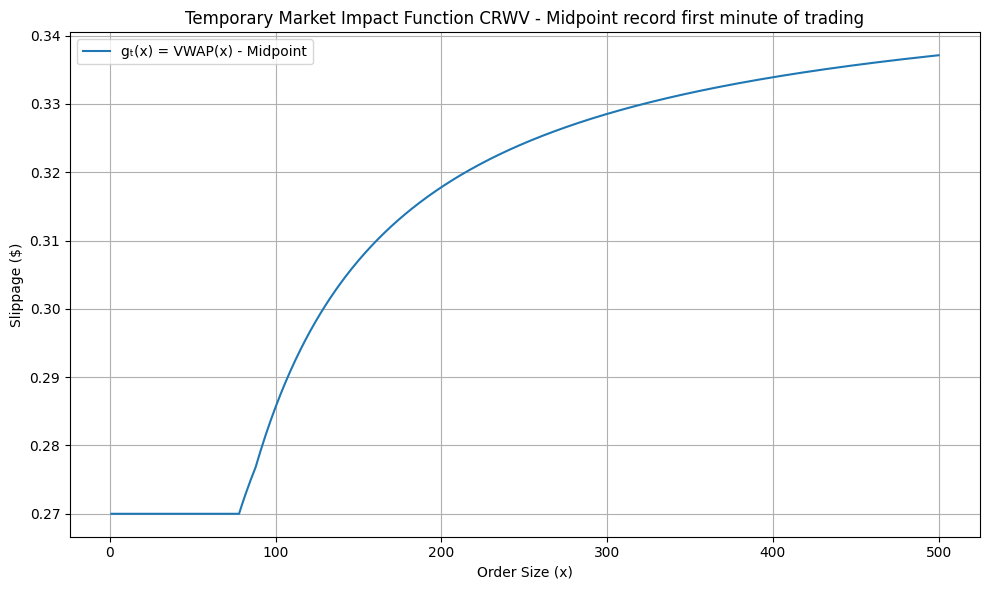

In [9]:
# Plot for the 10th minute snapshot - CRWV
plot_temporary_impact(snapshot_df.iloc[0])

In [10]:
# Save the allocation DataFrame to CSV
snapshot_df[['minute', 'slippage_per_share', 'x_t_allocated']].to_csv("slippage_allocations.csv", index=False)

# Download the CSV to your local machine
files.download("slippage_allocations.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>